<a href="https://colab.research.google.com/github/ikhwanafif05/Credit-Risk-Modelling-Tools/blob/main/Portfolio_Stress_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[06:18:03] Initializing Portfolio Engine...
[06:18:03] Portfolio Loaded. Total Exposure: RM 1,619.8M
[06:18:03] Running Scenario: +250bps Interest Rate Shock...
[06:18:04] Scenario Complete.
 > Base ECL: RM 22.44M
 > Stressed ECL: RM 30.57M
 > P&L Impact (Provision Increase): RM 8.12M
[06:18:06] Dashboard exported: Executive_Risk_Dashboard_250bps.png


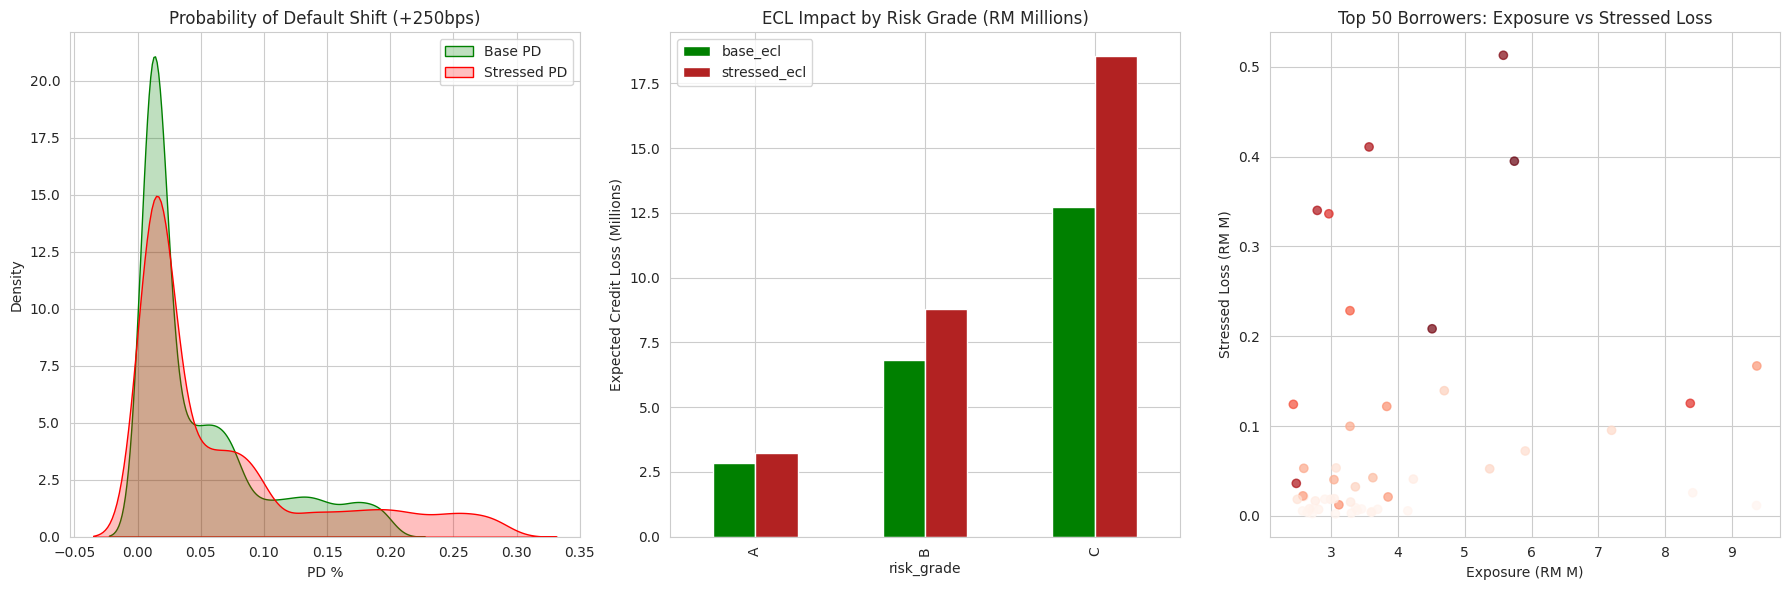

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# ==============================================================================
# ENTERPRISE STRESS TESTING ENGINE
# Author: Ikhwan Afif
# Architecture: Object-Oriented (OOP) for scalability
# Standards: Aligned with IFRS 9 ECL & ICAAP Stress Testing Frameworks
# ==============================================================================

class PortfolioStressEngine:
    def __init__(self, num_loans=2000):
        """
        Initializes the engine with a synthetic portfolio of corporate loans.
        Simulates segmentation by Risk Grade (A=Safe, B=Mid, C=Risky).
        """
        np.random.seed(42)
        print(f"[{datetime.now().strftime('%H:%M:%S')}] Initializing Portfolio Engine...")

        # Generate Synthetic Data
        self.data = pd.DataFrame({
            'loan_id': range(1000, 1000 + num_loans),
            'segment': np.random.choice(['Corporate', 'SME', 'Retail'], num_loans, p=[0.3, 0.4, 0.3]),
            'risk_grade': np.random.choice(['A', 'B', 'C'], num_loans, p=[0.5, 0.3, 0.2]),
            'ead': np.random.lognormal(mean=12, sigma=1.2, size=num_loans), # Exposure at Default
            'base_pd': np.zeros(num_loans),
            'lgd': np.random.beta(2, 5, size=num_loans) # Loss Given Default (Avg ~30%)
        })

        # Assign PDs based on Risk Grade (A is safer than C)
        self.data.loc[self.data['risk_grade'] == 'A', 'base_pd'] = np.random.uniform(0.005, 0.02, sum(self.data['risk_grade']=='A'))
        self.data.loc[self.data['risk_grade'] == 'B', 'base_pd'] = np.random.uniform(0.02, 0.08, sum(self.data['risk_grade']=='B'))
        self.data.loc[self.data['risk_grade'] == 'C', 'base_pd'] = np.random.uniform(0.08, 0.20, sum(self.data['risk_grade']=='C'))

        # Calculate Initial Expected Credit Loss (ECL = PD * LGD * EAD)
        self.data['base_ecl'] = self.data['base_pd'] * self.data['lgd'] * self.data['ead']

        print(f"[{datetime.now().strftime('%H:%M:%S')}] Portfolio Loaded. Total Exposure: RM {self.data['ead'].sum()/1e6:,.1f}M")

    def run_stress_scenario(self, rate_shock_bps):
        """
        Executes a stress scenario.
        Logic: Riskier grades (C) have higher elasticity to rate shocks than Safer grades (A).
        """
        print(f"[{datetime.now().strftime('%H:%M:%S')}] Running Scenario: +{rate_shock_bps}bps Interest Rate Shock...")

        shock_pct = rate_shock_bps / 10000

        # Define Elasticity (Sensitivity) by Risk Grade
        # "Grade C" borrowers are 3x more sensitive to rate hikes than "Grade A"
        elasticity_map = {'A': 5.0, 'B': 10.0, 'C': 15.0}

        # Apply Logic
        def apply_shock(row):
            elasticity = elasticity_map[row['risk_grade']]
            # Exponential Stress Formula: New PD = Old PD * exp(shock * elasticity)
            stressed_pd = row['base_pd'] * np.exp(shock_pct * elasticity)
            return min(stressed_pd, 1.0) # Cap at 100%

        self.data['stressed_pd'] = self.data.apply(apply_shock, axis=1)
        self.data['stressed_ecl'] = self.data['stressed_pd'] * self.data['lgd'] * self.data['ead']

        # Calculate Impact
        self.total_ecl_base = self.data['base_ecl'].sum()
        self.total_ecl_stress = self.data['stressed_ecl'].sum()
        self.delta_ecl = self.total_ecl_stress - self.total_ecl_base

        print(f"[{datetime.now().strftime('%H:%M:%S')}] Scenario Complete.")
        print(f" > Base ECL: RM {self.total_ecl_base/1e6:,.2f}M")
        print(f" > Stressed ECL: RM {self.total_ecl_stress/1e6:,.2f}M")
        print(f" > P&L Impact (Provision Increase): RM {self.delta_ecl/1e6:,.2f}M")

    def generate_dashboard(self, rate_shock_bps):
        """
        Generates a 3-panel Executive Dashboard for Risk Committees.
        """
        sns.set_style("whitegrid")
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Plot 1: PD Shift Distribution (The "Risk Migration" View)
        sns.kdeplot(self.data['base_pd'], ax=axes[0], color='green', fill=True, label='Base PD')
        sns.kdeplot(self.data['stressed_pd'], ax=axes[0], color='red', fill=True, label='Stressed PD')
        axes[0].set_title(f"Probability of Default Shift (+{rate_shock_bps}bps)")
        axes[0].set_xlabel("PD %")
        axes[0].legend()

        # Plot 2: Impact by Risk Grade (The "Segmentation" View)
        grade_impact = self.data.groupby('risk_grade')[['base_ecl', 'stressed_ecl']].sum() / 1e6
        grade_impact.plot(kind='bar', ax=axes[1], color=['green', 'firebrick'])
        axes[1].set_title("ECL Impact by Risk Grade (RM Millions)")
        axes[1].set_ylabel("Expected Credit Loss (Millions)")

        # Plot 3: Concentration Risk (The "Whale" View)
        # Show top 50 exposures and their stress impact
        top_exposure = self.data.nlargest(50, 'ead')
        axes[2].scatter(top_exposure['ead']/1e6, top_exposure['stressed_ecl']/1e6,
                        c=top_exposure['stressed_pd'], cmap='Reds', alpha=0.7)
        axes[2].set_title("Top 50 Borrowers: Exposure vs Stressed Loss")
        axes[2].set_xlabel("Exposure (RM M)")
        axes[2].set_ylabel("Stressed Loss (RM M)")

        plt.tight_layout()
        plt.savefig(f'Executive_Risk_Dashboard_{rate_shock_bps}bps.png')
        print(f"[{datetime.now().strftime('%H:%M:%S')}] Dashboard exported: Executive_Risk_Dashboard_{rate_shock_bps}bps.png")

# ==============================================================================
# EXECUTION BLOCK
# ==============================================================================
if __name__ == "__main__":
    # 1. Initialize Engine
    engine = PortfolioStressEngine(num_loans=5000)

    # 2. Run Stress Test (Crisis Scenario: +250 bps)
    engine.run_stress_scenario(rate_shock_bps=250)

    # 3. Generate Executive Report
    engine.generate_dashboard(rate_shock_bps=250)